In [17]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [76]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from glob import glob

In [35]:
# file_pattern = 'BTCUSDT-trades-2024-01-*.csv'
# file_names = glob(file_pattern)

# total_df = pd.concat((pd.read_csv(f) for f in file_names), ignore_index=True)

# total_df.to_csv('BTCUSDT-trades-2024-01-combined.csv', index=False)

In [36]:
data = pd.read_csv('BTCUSDT-trades-2024-01-combined.csv')
data.head()

,id,price,qty,quote_qty,time,is_buyer_maker
0,4426785098,42314.0,0.033,1396.362,1704067200006,False
1,4426785099,42314.0,0.215,9097.510,1704067200006,False
2,4426785100,42314.0,0.100,4231.400,1704067200022,False
3,4426785101,42314.0,0.512,21664.768,1704067200022,False
4,4426785102,42314.0,0.007,296.198,1704067200022,False


In [37]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

- 데이터에서 1시간 간격의 ohlcv 형식으로 변환하는 함수
- ohlcv로 주가 변동성 계산하는 함수

In [38]:
# 함수를 실행한 후 반환값을 변수에 저장
ohlcv_data = convert_tick_to_ohlcv(data)

print(ohlcv_data.head())

                        Open     High      Low    Close    Volume
time                                                             
2024-01-01 00:00:00  42314.0  42603.2  42289.6  42503.5  8459.477
2024-01-01 01:00:00  42503.5  42832.0  42462.0  42647.9  9043.411
2024-01-01 02:00:00  42647.9  42676.9  42530.0  42620.4  4653.067
2024-01-01 03:00:00  42620.5  42630.0  42270.0  42369.8  8119.880
2024-01-01 04:00:00  42369.8  42439.8  42235.2  42436.6  6356.536


<Axes: >

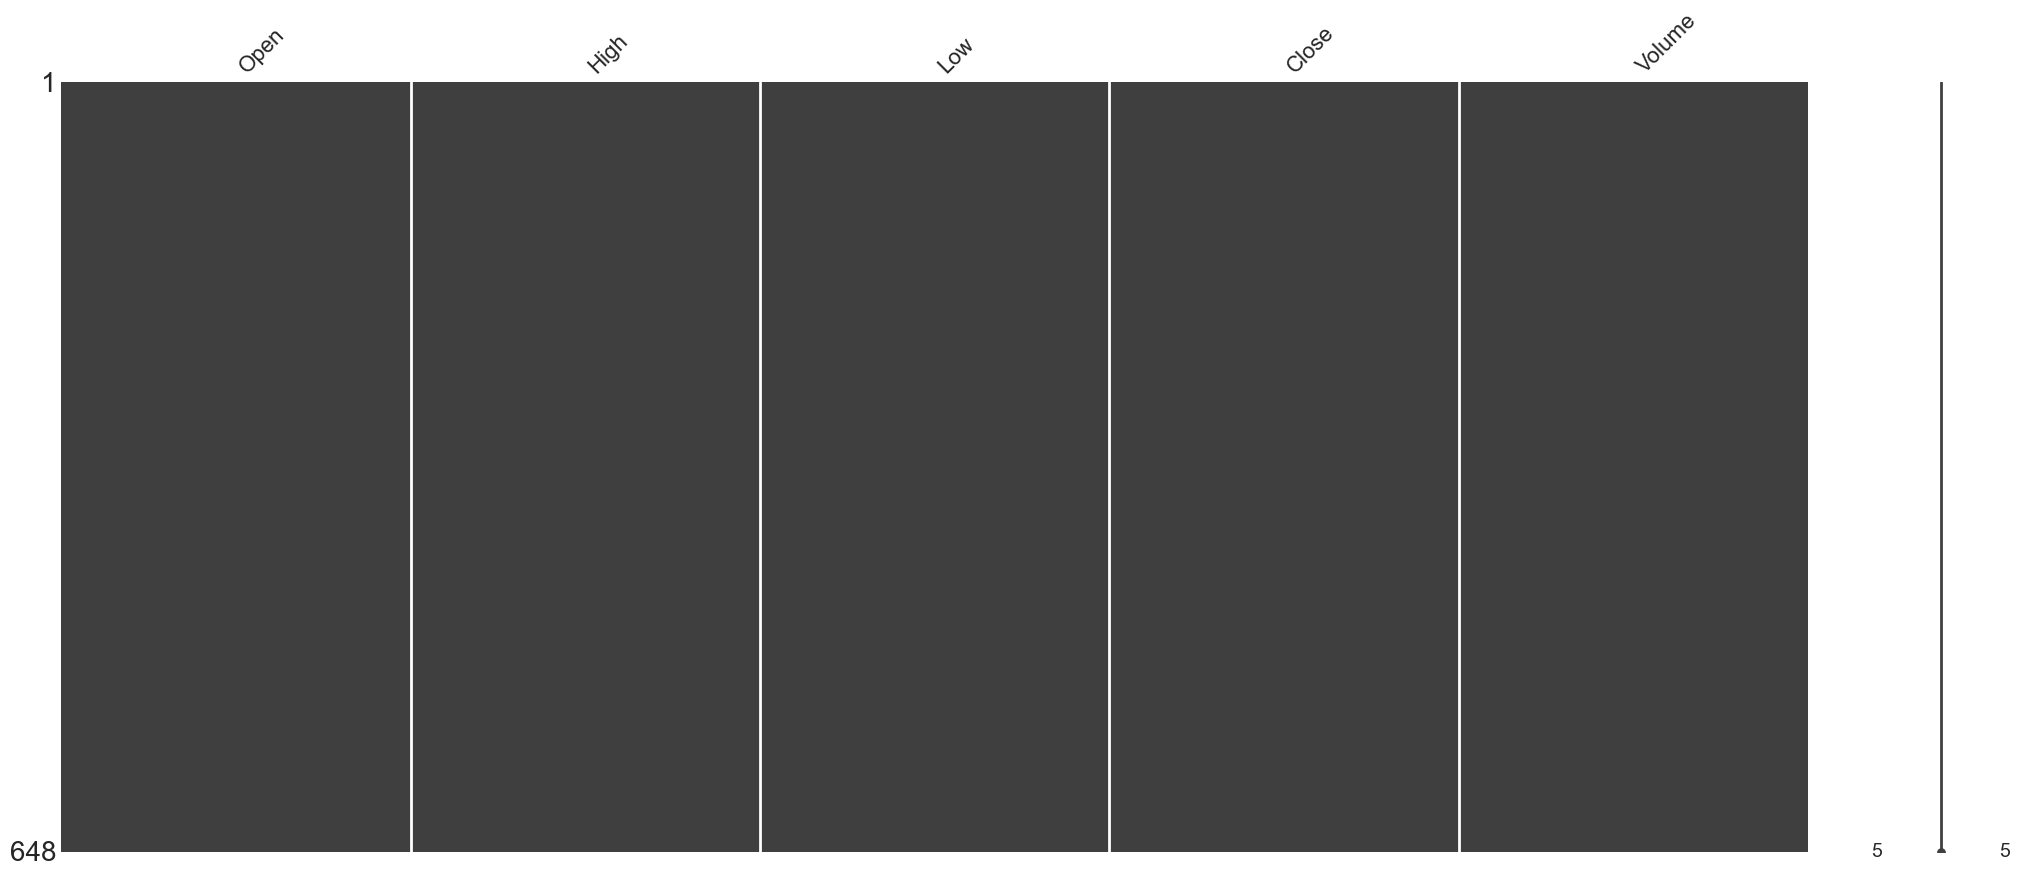

In [39]:
import missingno as msno
msno.matrix(ohlcv_data)

In [40]:
from sklearn.impute import KNNImputer
# K-최근접 이웃 방법으로 결측치 대체

# 파라미터 설정
imputer = KNNImputer(n_neighbors=5)

# fit_transform 메서드를 사용하여 결측치 대체
ohlcv_data_imputed = imputer.fit_transform(ohlcv_data)

# 결과를 DataFrame으로 변환
ohlcv_data_imputed = pd.DataFrame(ohlcv_data_imputed, columns=ohlcv_data.columns, index=ohlcv_data.index)

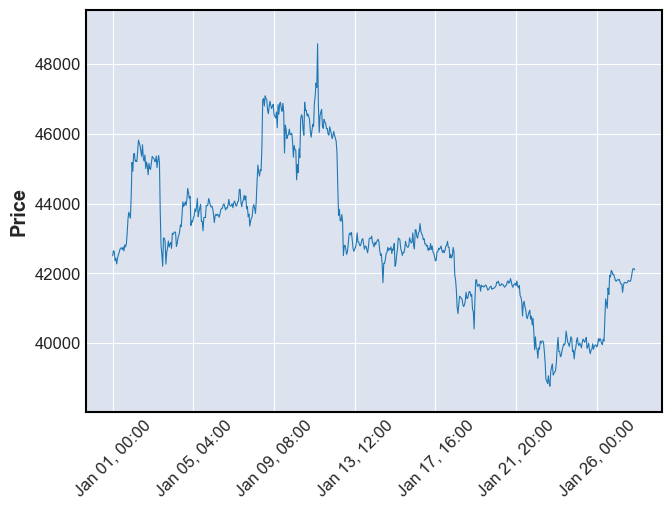

In [41]:
mpf.plot(ohlcv_data_imputed, type='line')

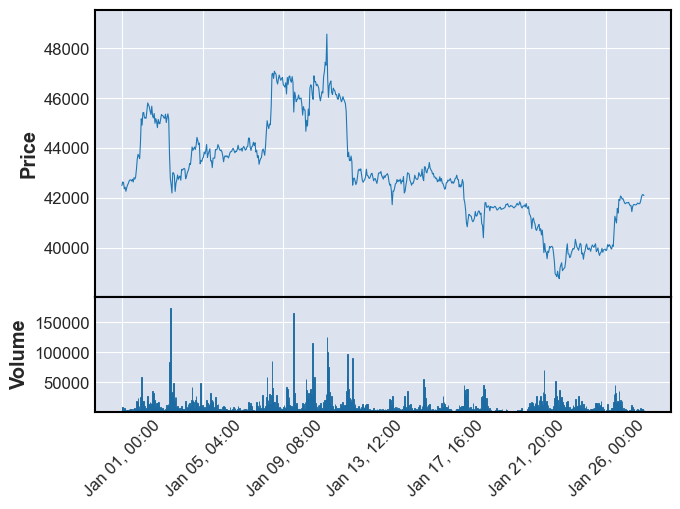

In [42]:
mpf.plot(ohlcv_data_imputed, volume = True, type='line')

In [43]:
Op=np.array(ohlcv_data_imputed["Open"])
Hi=np.array(ohlcv_data_imputed["High"])
Lo=np.array(ohlcv_data_imputed["Low"])
Cl=np.array(ohlcv_data_imputed["Close"])
V=np.array(ohlcv_data_imputed["Volume"])

In [44]:
input=np.column_stack((Op,Hi,Lo,V))
output=Cl

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

In [46]:
from sklearn.preprocessing import StandardScaler

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor
RF_sp = RandomForestRegressor()

In [48]:
# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [49]:
from sklearn.model_selection import GridSearchCV

# 그리드 서치
grid_search = GridSearchCV(RF_sp, param_grid, cv=5, scoring='explained_variance')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='explained_variance')

In [50]:
# 최적의 하이퍼파라미터
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

최적의 하이퍼파라미터: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [51]:
# 최적의 모델
RF_best = grid_search.best_estimator_

# 테스트 세트에 대한 예측
predictions = RF_best.predict(X_test_scaled)

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 모델 평가
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'R-squared: {r_squared}')
print(f'Explained Variance Score: {explained_variance}')

mse: 17684.83238237875
rmse: 132.98433134162366
mae: 90.69800817040719
R-squared: 0.99529944781559
Explained Variance Score: 0.9954192336459445


In [53]:
from sklearn.metrics import mean_absolute_percentage_error

mape_result = mean_absolute_percentage_error(y_test, predictions)
print(f'MAPE: {mape_result}')

MAPE: 0.002105045716134598
